Install Dependencies

In [287]:
# %pip install transformers
# %pip install pyarabic
# %pip install sentencepiece
# %pip install tokenizers
# %pip install protobuf
# %pip install anytree
# %pip install SentencePiece
# %pip install camel_tools
# %pip install deep_translator
# %pip install langid
# %pip install farasapy
# %pip install ipywidgets
# %pip install spacy
# %pip install nltk
# %pip install defaultdict
# %pip install tqdm
# %pip install re
# %pip install sklearn
# %pip install wordcloud
# %pip install matplotlib
# %pip install numpy
%pip install wordcloud
# %install pytorch , see docs from link https://pytorch.org/get-started/locally/#windows-verification

Note: you may need to restart the kernel to use updated packages.


Text Extraction from Dataset

In [288]:
import zipfile
import os
from tqdm import tqdm

extracted_text = []

# Specify the path to your zip file and the directory to extract it to
zip_file_path = 'dataset.zip'
extract_to = 'dataset'

# Step 1: Unzip the folder
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)  # Extract to a folder

print("Folder extracted successfully.\n")

# Step 2: Access the text file
extracted_folder = os.path.join(extract_to, 'Al_Mokhbir_Al_Eqtisadi/raw_data')

# Collect the list of files first to show progress properly
text_files = []

# Loop through all files and subdirectories in the folder to collect text files
for root, dirs, files in os.walk(extracted_folder):
    for file_name in files:
        if file_name.endswith('.txt'):
            file_path = os.path.join(root, file_name)
            text_files.append(file_path)

with tqdm(text_files, desc="Adding Files", unit="file") as pbar:
    for file_path in pbar:
        file_name = os.path.basename(file_path)

        # Open and read the text file
        with open(file_path, 'r', encoding='utf-8') as f:
            content = f.read()

        # Appending to the extracted_text list
        extracted_text.append({'name': file_name.replace(".txt", ""), 'content': content})

        # Update progress bar dynamically with the current file name being processed
        pbar.set_postfix_str(f"\033[92m {file_name.replace(".txt", "")}")

print("\nText Extracted Successfully.")

Folder extracted successfully.



Adding Files: 100%|██████████| 222/222 [00:09<00:00, 24.45file/s,  لماذا_يخسر_أمواله_كل_من_يراهن_ضد_بنك_اليابان_وكيف_أصبح_صانع_الأرامل]                             


Text Extracted Successfully.


Dependency Function for English Translation to Arabic

In [289]:
import langid
from deep_translator import GoogleTranslator
import spacy
import re
import nltk
import string
from collections import defaultdict
nltk.download('punkt')

# Load the English spaCy model (handles English entities)
nlp = spacy.load("en_core_web_sm")

# Caching translated words to avoid redundant calls
translation_cache = defaultdict(str)

translator = GoogleTranslator(source='en', target='ar')

# Function to clean up extra spaces in Arabic text and handle "ل" + "ال" cases
def clean_arabic_spacing(text):
    text = re.sub(r'\bال\s+', 'ال', text)  # Remove spaces between "ال" and the following word
    text = re.sub(r'\bل\s+ال', 'لل', text)  # Merge "ل" and "ال" into "لل"
    text = re.sub(r'\bل\s+', 'ل', text)  # Remove spaces between "ل" and the following word
    text = re.sub(r'\bو\s+', 'و', text)  # Remove spaces between "و" and the following word
    return text

# Function to detect language and translate English words, while excluding named entities
def translate_english_to_arabic(text):
    # Initialize the translator
    
    # Use NLTK's word tokenization (handles punctuation better)
    words = nltk.word_tokenize(text)
    
    # Process the text with spaCy to identify named entities
    doc = nlp(text)
    named_entities = {ent.text for ent in doc.ents}  # Set of named entities
    
    # List to hold the final translated text
    translated_words = []
    
    # Temporary list to collect English words for batch translation
    english_words = []
    word_punctuation_map = {}

    # Iterate through each word
    for word in words:
        # Remove punctuation from the word
        word_cleaned = word.strip(string.punctuation)
        
        try:
            # Detect the language of the word
            lang, _ = langid.classify(word_cleaned)
            
            # If the word is in English and not a named entity, collect for translation
            if lang == 'en' and word_cleaned not in named_entities:
                english_words.append(word_cleaned)
                # Store the punctuation of the word
                word_punctuation_map[word_cleaned] = ''.join([char for char in word if char in string.punctuation])
            else:
                # If the word is already in Arabic or is a named entity, keep it as is
                translated_words.append(word)
        
        except:
            # In case of an error (e.g., detecting numbers), keep the word as is
            translated_words.append(word)

    # If there are any English words, translate them in batch
    if english_words:
        # Convert the list of words into a sentence or chunk
        sentence_to_translate = ' '.join(english_words)

        # Check cache first to avoid redundant translations
        if sentence_to_translate not in translation_cache:
            # Translate the entire chunk to Arabic
            translated_batch = translator.translate(sentence_to_translate)
            # Cache the result for future use
            translation_cache[sentence_to_translate] = translated_batch
        else:
            # If cached, retrieve the translated text
            translated_batch = translation_cache[sentence_to_translate]

        # Split the translated text into words
        translated_batch_words = translated_batch.split()

        # Check if the translated batch words match the number of original words
        if len(translated_batch_words) == len(english_words):
            # Map the translated words back to their original positions
            for i, word in enumerate(english_words):
                translated_word = translated_batch_words[i]
                punctuation = word_punctuation_map.get(word, '')
                translated_words.append(translated_word + punctuation)
        else:
            # Handle mismatch by translating each word individually (fallback mechanism)
            for word in english_words:
                translated_word = translator.translate(word)
                punctuation = word_punctuation_map.get(word, '')
                translated_words.append(translated_word + punctuation)

    # Join the list back into a string
    translated_text = ' '.join(translated_words)
    
    # Clean up Arabic spacing
    return clean_arabic_spacing(translated_text)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aboue\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Data Cleaning

In [290]:
import re


def removeSeparateLetters(text):
    # Regex pattern to match standalone Arabic or English letters
    pattern = r'(?<!\S)[\u0600-\u06FFa-zA-Z](?!\S)'

    # Remove standalone letters
    filtered_text = re.sub(pattern, ' ', text)

    return filtered_text

def removeSquareBracketsIncludingWords(text):
    return  re.sub(r'\[.*?\]', '', text)

def removeExtraSpaces(text):
    return re.sub(r'\s+', ' ', text).strip()

def removeSentenceSpaces(text):
    return text.replace("\n"," ")

def removeUnwantedUnicode(text):
    # Remove Unicode control characters (e.g., U+200F)
    text = re.sub(r'[\u200E\u200F]', '', text)
    
    # Remove non-Arabic and non-English printable characters
    text = re.sub(r'[^\u0600-\u06FF\u0750-\u077Fa-zA-Z0-9\s.,!?]', '', text)
    
    # Normalize spaces (remove extra spaces)
    text = ' '.join(text.split())
    
    return text
    

def clean_text(text):
    cleaned_text = text
    
    cleaned_text = removeSquareBracketsIncludingWords(cleaned_text)

    cleaned_text = removeExtraSpaces(cleaned_text)

    cleaned_text = removeSentenceSpaces(cleaned_text)
  
    cleaned_text = removeSeparateLetters(cleaned_text)

    cleaned_text = removeUnwantedUnicode(cleaned_text)
    
    return cleaned_text


print("\nCleaning Data\n")

cleaned_text = []

# Ensure output directory exists
output_dir = "output/cleaned_data"
os.makedirs(output_dir, exist_ok=True)

with tqdm(text_files,bar_format="{l_bar}{bar}") as pbar:
    for episode in extracted_text:
        
        cleaned = clean_text(episode['content'])
        cleaned_text.append(cleaned)
        
        # Generate the output filename
        filename = episode['name'] + ".txt"
        filepath = os.path.join(output_dir, filename)
        
        # Save the cleaned text to the file
        with open(filepath, 'w', encoding='utf-8') as f:
            f.write(cleaned)
        

        pbar.update(1)


print("\nData Cleaned successfully")


Cleaning Data



100%|██████████


Data Cleaned successfully


Normalization

In [291]:
from pyarabic.araby import strip_tashkeel, strip_small
from camel_tools.utils.normalize import normalize_alef_maksura_ar
from camel_tools.utils.normalize import normalize_alef_ar
from camel_tools.utils.normalize import normalize_teh_marbuta_ar
from camel_tools.utils.normalize import normalize_alef_ar

def removeAuthorEndSentence(text):
    possibleEndSentences = [
        'عجبتكم الحلقه وحابين تشوفونا اشتركوا القناه استنونا حلقات جديده باذن الله سلام',
        'وحابين تشوفونا تاني اشتركوا القناه استنونا حلقات جديده باذن الله سلام',
        'وحابين تشوفونا اشتركوا القناه استنونا حلقات جديده باذن الله سلام',
        'اشتركوا في القناه واستنونا حلقات جديده باذن الله سلام',
        'اشتركوا القناه واستنونا حلقات جديده باذن الله سلام',
        'اشتركوا القناه استنونا حلقات جديده باذن الله سلام',
        'اشتركوا في القناة واستنونا في حلقات جديدة باذن الله سلام',
        'القناه استنونا حلقات جديده باذن الله السلام',
        'الحلقه وحابين تشوفونا تاني اشتركوا',
        'واستنونا حلقات جديده باذن الله سلام',
        'واستنونا حلقات جديده باذ الله سلام',
        'وحابين تشوفونا تاني',
        'تشوفونا تاني',
        'الله سلام'
    ]

    possibleEndSentences2 = [
        'هتابع اجاباتكم التعليقات',
        'هتابع في اجاباتكم التعليقات'
    ] 
    
    # Define the start point as 90% of the text length to search from
    start_point = int(len(text) * 0.8)
    
    # Search the last 10% of the text for any of the possible end sentences
    last_text = text[start_point:]
    
    for sentence in possibleEndSentences:
        if sentence in last_text:
            # Remove the found sentence from the full text
            text = text.replace(sentence, '')
            last_text = text[start_point:]
            
    
    for sentence in possibleEndSentences2:
        if sentence in last_text:
            # Remove the found sentence from the full text
            text = text.replace(sentence, '')
            last_text = text[start_point:]
            
    
    return text


def removeAuthorStartSentence(text):
    possibleEndSentences = [
      'اشرف ابراهيم','دا المخبر الاقتصادي',
    ]
    
    # Define the start point as 90% of the text length to search from
    end_point = int(len(text) * 0.3)
    
    # Search the last 10% of the text for any of the possible end sentences
    last_text = text[:end_point]
    
    for sentence in possibleEndSentences:
        if sentence in last_text:
            # Remove the found sentence from the full text
            text = text.replace(sentence, '')
            last_text = text[:end_point]

    
    return text


def removeAuthorName(text):
    text = text.replace('اشرف','')
    
    return text


def normalizeText(text = "",r_s = True):
    # normalizedText = translate_english_to_arabic(text)
    normalizedText = text

    normalizedText = strip_tashkeel(normalizedText)
    normalizedText = strip_small(normalizedText)
    normalizedText = normalize_alef_ar(normalizedText)
    normalizedText = normalize_alef_maksura_ar(normalizedText)
    normalizedText = normalize_teh_marbuta_ar(normalizedText)

    normalizedText = removeAuthorStartSentence(normalizedText)

    normalizedText = removeAuthorEndSentence(normalizedText)
    
    normalizedText = removeAuthorName(normalizedText)

    return normalizedText


def prepareArabicStopWords():
    # Path to stop-words file
    file_path = 'arabic_stop_words.txt'  # Replace with the actual path to your file

    # Openening the file and read the contents
    with open(file_path, 'r', encoding='utf-8') as file:
        #Reading all lines, strip to remove extra whitespace and create a list
        stopwords = [line.strip() for line in file]
        
    # normalize
    normalizedStopWords = [normalizeText(text=word,r_s=False) for word in stopwords]
    
    return normalizedStopWords

arabic_stopwords = prepareArabicStopWords()

normalizedData = []

print('\nNormalizing Data')
print()

# Ensure output directory exists
output_dir = "output/normalized_data"
os.makedirs(output_dir, exist_ok=True)

with tqdm(text_files,bar_format="{l_bar}{bar}") as pbar:
    for index, text in enumerate(cleaned_text):

        normalizedText = normalizeText(text)

        normalizedData.append(normalizedText)
        
        filename = extracted_text[index]['name'] + ".txt"
        filepath = os.path.join(output_dir, filename)
        
        # Save the normalized text to the file
        with open(filepath, 'w', encoding='utf-8') as f:
            f.write(normalizedText)
        

        pbar.update(1)

print("\nNormalization Completed")




Normalizing Data



100%|██████████


Normalization Completed


Tokenization

In [292]:

from pyarabic import araby

def tokenize(text):
    return araby.tokenize(text)

tokenizedDataPhaseOne = []

print('\nTokenizing Data \n')

with tqdm(text_files,bar_format="{l_bar}{bar}") as pbar:
    for text in normalizedData:
        tokenizedDataPhaseOne.append(tokenize(text))
        
        pbar.update(1)
        
print("\nTokenization Completed")




Tokenizing Data 



100%|██████████


Tokenization Completed


Step Words Removal

In [293]:
def removeStopWords(wordList):
    filteredWords = [word for word in wordList if word not in arabic_stopwords]
    return filteredWords


tokenizedDataPhaseOne = [removeStopWords(item) for item in tokenizedDataPhaseOne]

print("\Step words removal Completed")

<>:8: SyntaxWarning:

invalid escape sequence '\S'

<>:8: SyntaxWarning:

invalid escape sequence '\S'

C:\Users\aboue\AppData\Local\Temp\ipykernel_7944\1658496574.py:8: SyntaxWarning:

invalid escape sequence '\S'



\Step words removal Completed


Stemming

In [294]:
# https://github.com/mohataher/arabic-stop-words/blob/master/list.txt --> stop words
# https://hajar-iba.medium.com/camel-tools-a-python-toolkit-for-arabic-nlp-ba9f1d2e8cb7 --> article link

# from farasa.stemmer import FarasaStemmer
# stemmer =  FarasaStemmer(interactive=True)

from nltk.stem.isri import ISRIStemmer

stemmer = ISRIStemmer()

def stemmize(word):
    return stemmer.suf32(word)
    # return word
    # Farasa stemmer, after testing not good output as nltk
    # return stemmer.stem(word)  
tokenizedDataPhaseOne = [[stemmize(token)for token in tokens] for tokens in tokenizedDataPhaseOne]

textAfterPhaseOneTokenization = [' '.join(tokens) for tokens in tokenizedDataPhaseOne]


Analysis

In [ ]:
from bidi.algorithm import get_display
import os
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import arabic_reshaper # this was missing in your code

allData = ' '.join([str(element) for element in textAfterPhaseOneTokenization])
# os.chdir("C:")
data = arabic_reshaper.reshape(allData)
data = get_display(data) # add this line

WordCloud = WordCloud(font_path='arial', background_color='white', mode='RGB', width=3000, height=1300).generate(data)

plt.title("wordcloud")
plt.imshow(WordCloud)
plt.axis("off")
plt.show()

Tokenization but using the tokenizer of the used model from transformers package

In [295]:
from transformers import AutoTokenizer, BertModel

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("faisalq/bert-base-arabic-senpiece")
print("Tokenizer Created")
# Tokenize the input text
inputs = tokenizer(text=textAfterPhaseOneTokenization, padding=True,max_length=128 ,truncation=True, return_tensors="pt")

print("Data Tokenization Completed")

Tokenizer Created
Data Tokenization Completed


Create Model & Pass Inputs

In [296]:
import torch

model = BertModel.from_pretrained("faisalq/bert-base-arabic-senpiece")
print("Model Created")
with torch.no_grad():
    outputs = model(**inputs)


Model Created


Extract text in the form of numerical representations (embeddings) from the model

In [297]:
sentence_embedding = outputs.last_hidden_state[:, 0, :].squeeze()
import numpy as np

# Convert the PyTorch tensor embeddings to a NumPy array
embeddings_array = np.stack([embedding.numpy() for embedding in sentence_embedding])

In [316]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Normalize the embeddings
scaler = StandardScaler()
normalized_embeddings = scaler.fit_transform(embeddings_array)

# Define the number of clusters
num_clusters = 6  # Adjust this based on evaluation

# Apply K-Means clustering to the embeddings
kmeans = KMeans(n_clusters=num_clusters, n_init=50, random_state=42)

# Fit the model to the normalized embeddings
kmeans.fit(normalized_embeddings)

# Get the cluster labels for each text
cluster_labels = kmeans.labels_

Show Output

In [317]:
# %pip install plotly
from anytree import Node, RenderTree
import plotly.graph_objects as go
import plotly.express as px  # We'll use this to get colors

# Assuming `cluster_labels` and `extracted_text` are already available

# Create the root node
root = Node("All Clusters")

# Dictionary to store the cluster nodes
cluster_nodes = {}

# Loop through cluster labels and texts
for i, label in enumerate(cluster_labels):
    
    # Create a node for the cluster if it doesn't already exist
    if label not in cluster_nodes:
        cluster_nodes[label] = Node(f"Cluster {label}", parent=root)
    
    # Add a child node for the text file under the appropriate cluster node
    Node(extracted_text[i]['name'], parent=cluster_nodes[label])

# Function to create a tree structure for plotly
def create_tree_traces(node, x=0, y=0, dx=1, dy=1):
    traces = []
    labels = []
    hover_texts = []
    cluster_labels = []
    
    # Traverse the tree and collect node information
    for pre, _, n in RenderTree(node):
        labels.append(n.name)
        hover_texts.append(n.name)
        # Use the parent name to determine cluster label (unless it's the root)
        if n.parent and n.parent.name != "All Clusters":
            cluster_labels.append(n.parent.name)
        else:
            cluster_labels.append("All Clusters")
        traces.append((x, y))
        x += dx
        y -= dy
    
    return traces, labels, hover_texts, cluster_labels

# Create the tree traces
traces, labels, hover_texts, cluster_labels = create_tree_traces(root)

# Get unique clusters and create a color palette based on the number of clusters
unique_clusters = list(set(cluster_labels))
color_map = px.colors.qualitative.Plotly[:len(unique_clusters)]

# Create a dictionary to map clusters to colors
cluster_color_map = {cluster: color_map[i] for i, cluster in enumerate(unique_clusters)}

# Create a list of colors based on cluster labels
colors = [cluster_color_map[label] for label in cluster_labels]

# Create the plotly figure
fig = go.Figure(go.Treemap(
    labels=labels,
    parents=[""] * len(labels),  # We're using the root and cluster names for the parents
    values=[1] * len(labels),
    text=hover_texts,
    hoverinfo="text",
    marker=dict(colors=colors)  # Apply the colors based on clusters
))

# Update layout for better visualization
fig.update_layout(
    title="Grouped Topics by Cluster",
    margin=dict(t=40, l=0, r=0, b=0),
)

fig.show()

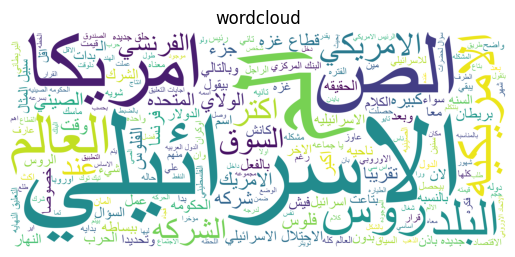

In [302]:
# Import necessary libraries
# from transformers import AutoTokenizer, BertModel, BertForSequenceClassification, Trainer, TrainingArguments
# import numpy as np
# import torch

# # Step 1: Load the Pretrained Tokenizer
# tokenizer = AutoTokenizer.from_pretrained("faisalq/bert-base-arabic-senpiece")

# # Add new tokens (e.g., English words) to the tokenizer
# new_tokens = ["hello", "world", "AI", "machine learning"]
# num_new_tokens = tokenizer.add_tokens(new_tokens)
# print(f"Added {num_new_tokens} new tokens. Updated vocabulary size: {len(tokenizer)}")

# # Step 2: Load the Pretrained Model and Resize Embeddings
# model = BertForSequenceClassification.from_pretrained("faisalq/bert-base-arabic-senpiece", num_labels=2)  # for binary classification
# model.resize_token_embeddings(len(tokenizer))
# print("Model embeddings resized to match new vocabulary size.")

# # Step 3: Prepare Dataset
# # Load a sample dataset (you can replace it with your own dataset)
# dataset = load_dataset("glue", "sst2")  # SST-2 dataset for binary sentiment analysis
# train_dataset = dataset["train"]
# test_dataset = dataset["test"]

# # Tokenize the dataset for training
# def tokenize_function(examples):
#     return tokenizer(examples["sentence"], padding=True, truncation=True, max_length=128)

# train_dataset = train_dataset.map(tokenize_function, batched=True)
# test_dataset = test_dataset.map(tokenize_function, batched=True)

# # Step 4: Define Training Arguments
# training_args = TrainingArguments(
#     output_dir="./results",               # Output directory
#     evaluation_strategy="epoch",          # Evaluate after each epoch
#     learning_rate=2e-5,                   # Learning rate
#     per_device_train_batch_size=16,       # Batch size for training
#     per_device_eval_batch_size=16,        # Batch size for evaluation
#     num_train_epochs=3,                   # Number of epochs
#     weight_decay=0.01,                    # Weight decay to prevent overfitting
#     logging_dir='./logs',                 # Directory for storing logs
#     logging_steps=10,                     # Log every 10 steps
# )

# # Step 5: Initialize the Trainer
# trainer = Trainer(
#     model=model,                          # The model to be trained
#     args=training_args,                   # Training arguments
#     train_dataset=train_dataset,          # Training dataset
#     eval_dataset=test_dataset,            # Evaluation dataset
#     tokenizer=tokenizer                   # Tokenizer
# )

# # Step 6: Fine-Tune the Model
# print("Starting training...")
# trainer.train()
# print("Training complete.")

# # Step 7: Save the Fine-Tuned Model and Tokenizer
# model.save_pretrained("./fine_tuned_model")
# tokenizer.save_pretrained("./fine_tuned_model")

# # Step 8: Use the Fine-Tuned Model for Inference
# inputs = tokenizer("السلام عليكم hello world", return_tensors="pt")
# with torch.no_grad():
#     outputs = model(**inputs)
# print("Inference complete.")


In [303]:
# from transformers import AutoTokenizer, BertForPreTraining
# import torch

# tokenizer = AutoTokenizer.from_pretrained("faisalq/bert-base-arabic-wordpiece")
# print("tokenizer ready")
# model = BertForPreTraining.from_pretrained("faisalq/bert-base-arabic-wordpiece",)
# print("model ready")

# # sp.encode('This is a test')



# # TODO:  Replace with dataset it also takes text
# inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
# print("input tokenized")
# outputs = model(**inputs)
# print("output ready")
# prediction_logits = outputs.prediction_logits
# seq_relationship_logits = outputs.seq_relationship_logits

In [304]:
# import getpass
# import os

# # if not os.environ.get("GROQ_API_KEY"):
# os.environ["GROQ_API_KEY"] = "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"

# print(os.environ.get("GROQ_API_KEY"))
# print("ENV preparation done")

# from langchain.chat_models import init_chat_model

# model = init_chat_model("llama3-8b-8192", model_provider="groq")

# print("model creation done")

In [305]:
# from langchain_core.messages import HumanMessage, SystemMessage

# messages = [
#     SystemMessage("Translate the following from English into Italian"),
#     HumanMessage("hi!"),
# ]

# print("message prepared")

# model.invoke(messages)